In [28]:
%matplotlib inline
from matplotlib import pyplot as plt

In [29]:
import datajoint as dj

In [30]:
schema = dj.schema('trasfer2')

In [31]:
@schema
class Source(dj.Lookup):
    definition = """
    name : char(12)
    ---
    image_url : varchar(255)
    """
    
    contents = (
    ('friesian', 'https://www.horseillustrated.com/wp-content/uploads/2019/03/friesian-horse-opener-ss-630x420.jpg'),
    ('irishsport', 'https://i0.wp.com/thepixelnomad.com/wp-content/uploads/2019/08/190621-Carrigfada-Diamond087-Bearbeitet.jpg?fit=1500%2C1000&ssl=1'),
    ('oldenburg', 'https://eurodressage.com/sites/default/files/styles/max_325x325/public/database-story-thumb/2019-09/auctions_vechta_gameofthrones_01.jpg?itok=sRz18H9b'),
    ('alteki', 'https://upload.wikimedia.org/wikipedia/commons/8/83/Dagat-Geli.jpg'),
    ('andulusian', 'https://www.thesprucepets.com/thmb/bw1sHnbB82dDhXgig903ziQjKpY=/960x0/filters:no_upscale():max_bytes(150000):strip_icc():format(webp)/GettyImages-1194308039-aefebed4140c4c61a0267e681f4272c9.jpg'),
    )

In [32]:
Source.drop()

`trasfer2`.`#source` (5 tuples)
Proceed? [yes, No]: no


In [36]:
import requests
import os

@schema
class Image(dj.Imported):
    definition = """
    -> Source
    ---
    image : longblob
    """
    
    def make(self, key):
        url = (Source & key).fetch1('image_url')
        tempfile = 'image.tmp'
        with open(tempfile, 'wb') as f:
            f.write(requests.get(url).content)
        self.insert1(dict(key, image=plt.imread(tempfile)))
        os.unlink(tempfile)

In [37]:
Image.populate(display_progress=True)

Image: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


In [35]:
#Image.drop()

`trasfer2`.`_image` (0 tuples)
Proceed? [yes, No]: yes
Tables dropped.  Restart kernel.


In [38]:
Image() * Source

*name          image      image_url     
+------------+ +--------+ +------------+
alteki         =BLOB=     https://upload
andulusian     =BLOB=     https://www.th
friesian       =BLOB=     https://www.ho
irishsport     =BLOB=     https://i0.wp.
oldenburg      =BLOB=     https://eurodr
 (Total: 5)

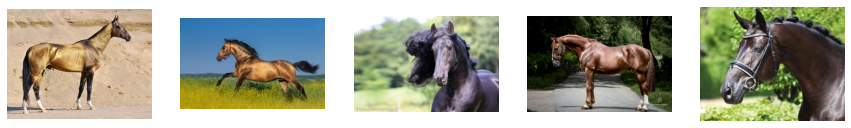

In [39]:
fig, ax = plt.subplots(1, len(Image()), figsize=(len(Image())*3,3))
for a, img in zip(ax, Image.fetch('image')):
    a.imshow(img)
    a.axis(False)

In [41]:
pip install imutils

  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25858 sha256=2811b295f2572f9090ec82481ce83a489a036c84b53f13f8f5475cbf5968ab2f
  Stored in directory: /home/ubuntu/.cache/pip/wheels/59/1b/52/0dea905f8278d5514dc4d0be5e251967f8681670cadd3dca89
Successfully built imutils
Note: you may need to restart the kernel to use updated packages.


In [42]:
import imutils

In [43]:
import numpy as np
import cv2

In [44]:
@schema
class Crop(dj.Computed):
    definition = """
    -> Image
    ---
    cropped_image : longblob
    """
    
    def make(self, key):
        img = (Image & key).fetch1('image')
        sz = min((img.shape[:2]))
        sz1 = (img.shape[0] - sz)//2
        sz2 = (img.shape[1] - sz)//2
        img = imutils.resize(img[sz1:sz1+sz, sz2:sz2+sz], width=600, height=600)
        self.insert1(dict(key, cropped_image=img))

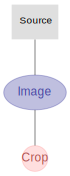

In [45]:
dj.Diagram(schema)

In [46]:
Crop.populate(display_progress=True)

Crop: 100%|██████████| 5/5 [00:01<00:00,  4.31it/s]


In [47]:
@schema
class Style(dj.Lookup):
    definition = """
    style_name      : varchar(30)
    """
    contents = (['udnie'], ['la_muse'], ['starry_night'], ['mosaic'])

In [49]:
ls models

la_muse.t7  mosaic.t7  starry_night.t7  udnie.t7


In [50]:
image = Crop.fetch('cropped_image', limit=1)[0]

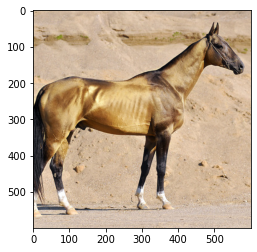

In [51]:
plt.imshow(image)

In [52]:
    net = cv2.dnn.readNetFromTorch('/home/ubuntu/datajoint-python/StyleTransfer/StyleTransfer/models/la_muse.t7')    
    image = imutils.resize(image, width=600)
    (h, w) = image.shape[:2]

    # construct a blob from the image, set the input, and then perform a
    # forward pass of the network
    blob = cv2.dnn.blobFromImage(image, 1.0, (w, h),
                                 (103.939, 116.779, 123.680), swapRB=False, crop=False)
    net.setInput(blob)
    output = net.forward()

    # reshape the output tensor, add back in the mean subtraction, and
    # then swap the channel ordering
    output = output.reshape((3, output.shape[2], output.shape[3]))
    output[0] += 103.939
    output[1] += 116.779
    output[2] += 123.680
    output = output.transpose(1, 2, 0)
    output = np.clip(output, 0, 255)
    output= output.astype('uint8')

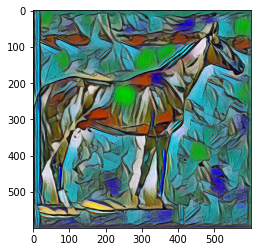

In [53]:
plt.imshow(output)

In [60]:
@schema
class Transfer(dj.Computed):
    definition = """
    -> Image
    -> Style
    ---
    art_image : longblob
    """
    
    def make(self, key):
        image = (Image & key).fetch1('image')
        style_name = (Style & key).fetch1('style_name')
        net = cv2.dnn.readNetFromTorch(f'/home/ubuntu/datajoint-python/StyleTransfer/StyleTransfer/models/{style_name}.t7')
        image = imutils.resize(image, width=800)
        (h, w) = image.shape[:2]

        # construct a blob from the image, set the input, and then perform a
        # forward pass of the network
        blob = cv2.dnn.blobFromImage(image, 1.0, (w, h),
                                     (103.939, 116.779, 123.680), swapRB=False, crop=False)
        net.setInput(blob)
        output = net.forward()

        # reshape the output tensor, add back in the mean subtraction, and
        # then swap the channel ordering
        output = output.reshape((3, output.shape[2], output.shape[3]))
        output[0] += 103.939
        output[1] += 116.779
        output[2] += 123.680
        output = output.transpose(1, 2, 0)
        output = np.clip(output, 0, 255)
        output= output.astype('uint8')
        self.insert1(dict(key, art_image=output))

In [61]:
#Transfer.drop()

In [62]:
Transfer.populate(display_progress=True)

Transfer: 100%|██████████| 20/20 [00:28<00:00,  1.44s/it]


In [63]:
Transfer()

*name          *style_name    art_image 
+------------+ +------------+ +--------+
alteki         la_muse        =BLOB=    
andulusian     la_muse        =BLOB=    
friesian       la_muse        =BLOB=    
irishsport     la_muse        =BLOB=    
oldenburg      la_muse        =BLOB=    
alteki         mosaic         =BLOB=    
andulusian     mosaic         =BLOB=    
friesian       mosaic         =BLOB=    
irishsport     mosaic         =BLOB=    
oldenburg      mosaic         =BLOB=    
alteki         starry_night   =BLOB=    
andulusian     starry_night   =BLOB=    
   ...
 (Total: 20)

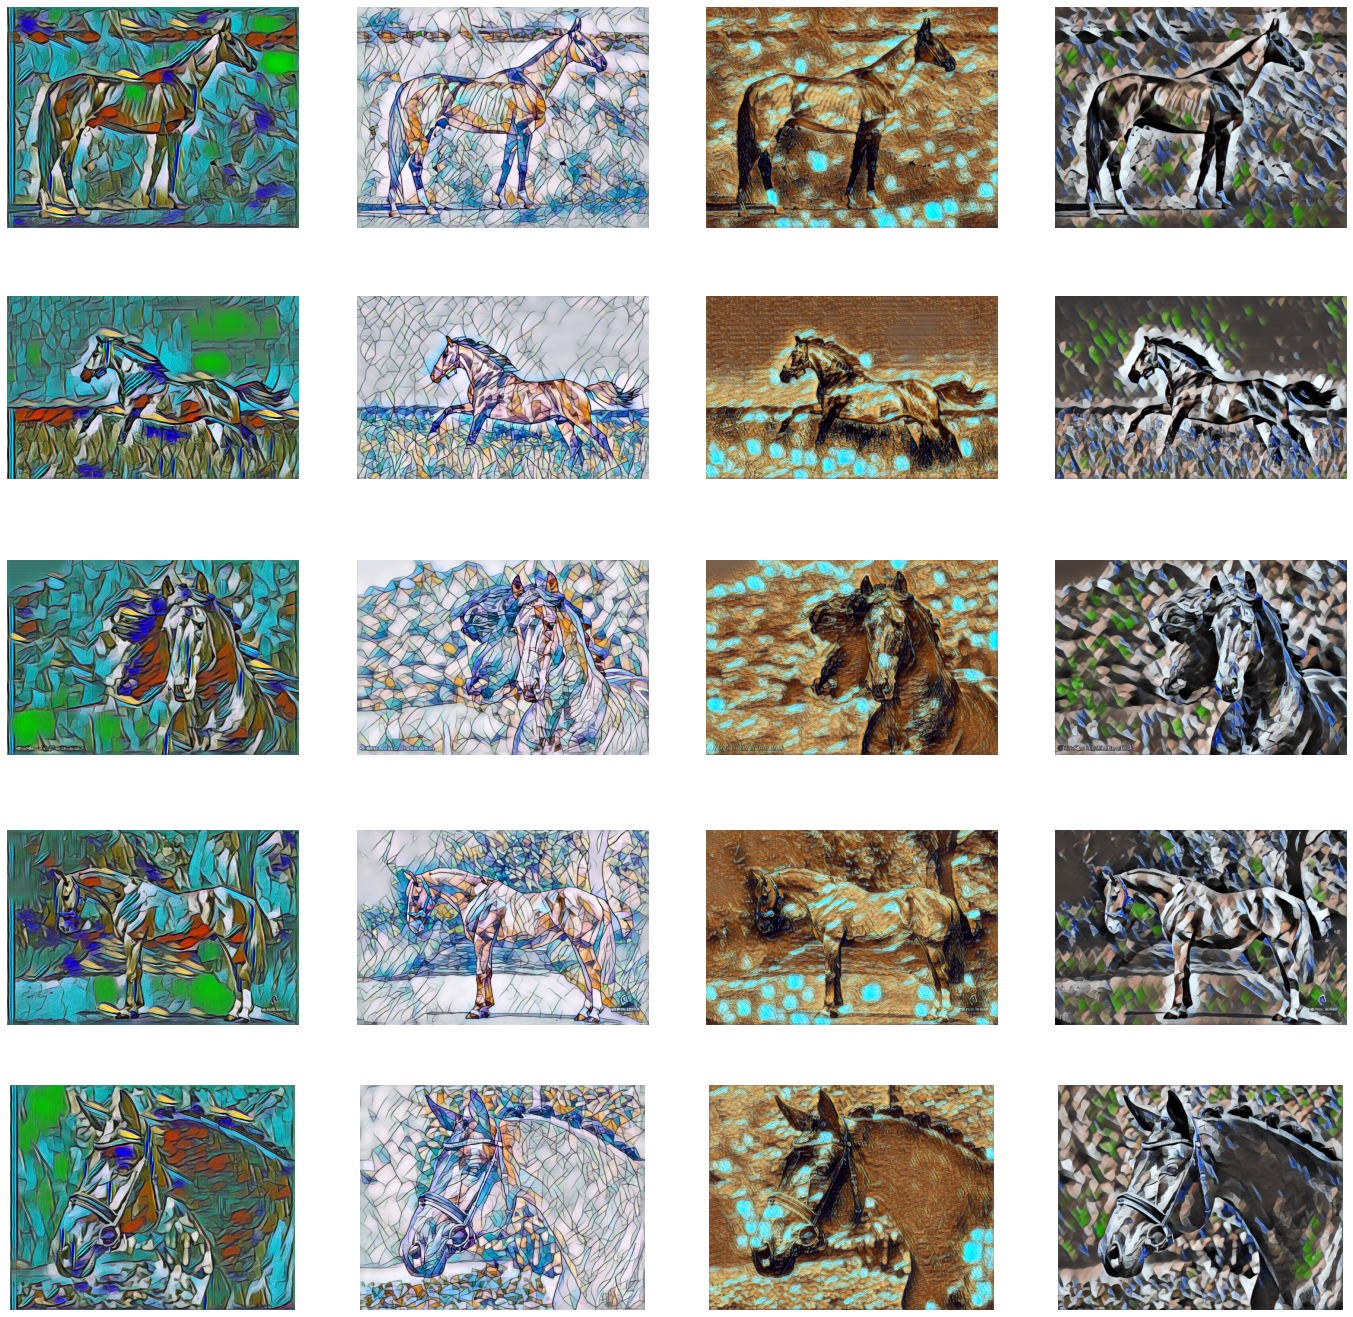

In [64]:
fig, axx = plt.subplots(5, 4, figsize=(24, 24))

for ax, img in zip(axx.flatten(), Transfer.fetch('art_image')):
    ax.imshow(img)
    ax.axis(False)

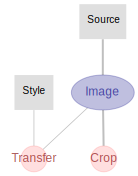

In [65]:
dj.Diagram(schema)

In [66]:
Image.populate(display_progress=True)
Transfer.populate(display_progress=True)

Image: 0it [00:00, ?it/s]
Transfer: 0it [00:00, ?it/s]
